In [1]:
import skimage      
from skimage import io, filters
from skimage import filters
from scipy.ndimage import sobel, interpolation
import skimage.color as color
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import eig
import cv2
import time

In [2]:
def extract_frame_cv2(video_path, time_ms, output_image_path):
    """
    Extracts a frame from a video at a specified time in milliseconds and saves it as an image using OpenCV.

    :param video_path: Path to the video file.
    :param time_ms: Time in milliseconds to extract the frame.
    :param output_image_path: Path to save the extracted frame image.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if video opened successfully
    if not cap.isOpened():
        raise IOError("Could not open video file")

    # Get the frames per second (fps) of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Calculate the frame number to capture based on the time (in milliseconds) and fps
    frame_number = int((time_ms / 1000) * fps)

    # Set the video position to the frame number
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    success, frame = cap.read()

    if not success:
        raise IOError("Could not read frame at time {} milliseconds".format(time_ms))

    # Save the frame as an image
    cv2.imwrite(output_image_path, frame)

    # Release the video capture object
    cap.release()

In [3]:
def read_video(file_path):
    cap = cv2.VideoCapture(file_path)
    # start_time = time.time()
    # duration = 5
    frames = []

    # Set the start position to 200 milliseconds
    start_time_milliseconds = 200
    cap.set(cv2.CAP_PROP_POS_MSEC, start_time_milliseconds)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))  # Convert to grayscale
    cap.release()
    
    return frames

In [4]:
video_path = 'redBall.mp4'  # Replace with your video path
time_ms = 200 # Extract a frame at 2 
output_image_path = 'frame.jpg'  # Replace with your desired output path

# Call the function
extract_frame_cv2(video_path, time_ms, output_image_path)

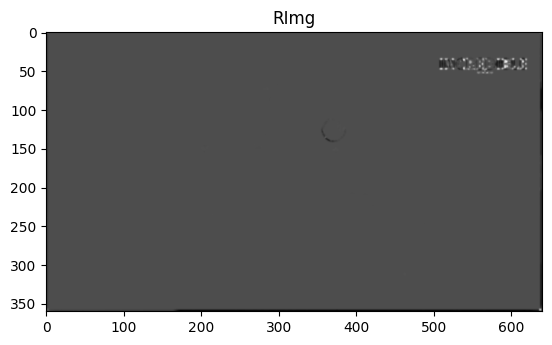

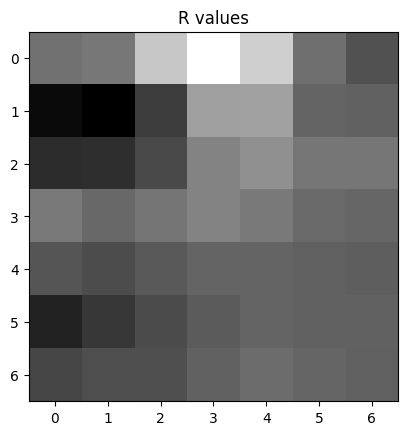

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


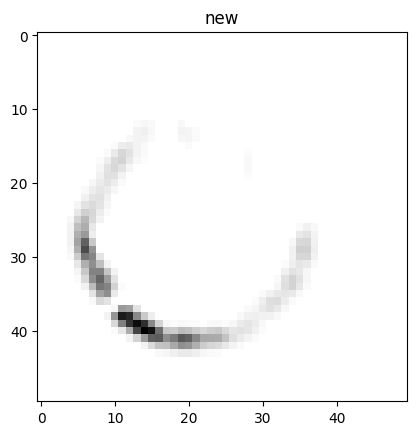

0.0


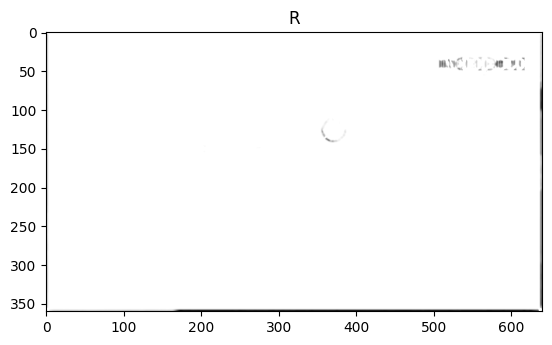

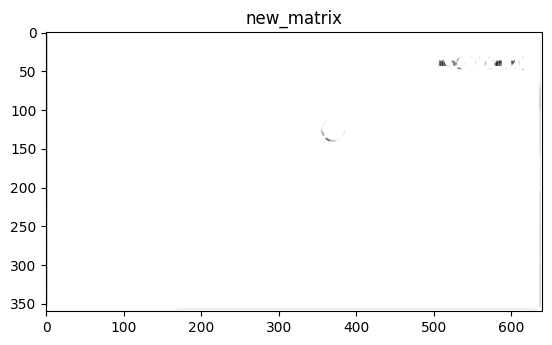

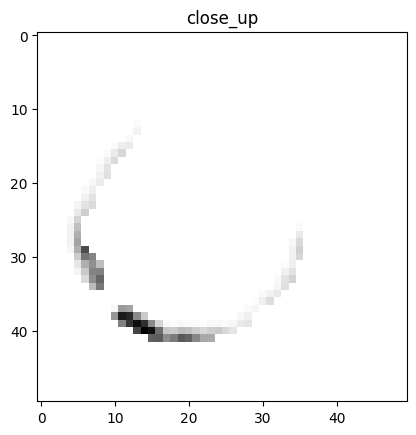

0.0


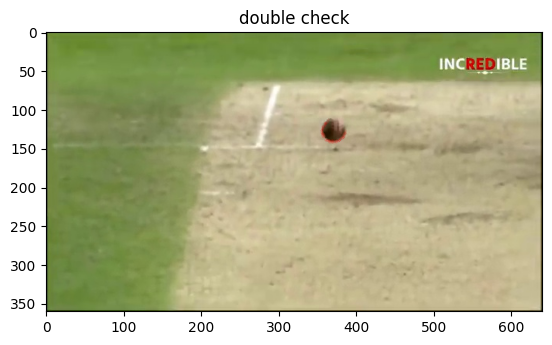

129


In [5]:
frame = io.imread('frame.jpg')
gray_frame = color.rgb2gray(frame)


sigmaI = 1
sigmaD = 0.7

def gaussDeriv2D(sigma):

    min = -np.ceil(3 * sigma)
    max = np.ceil(3 * sigma)

    xRange = np.arange(min, max + 1)    
    yRange = np.arange(min, max +1)

    X = np.array([[x for x in xRange] for y in yRange])
    Y =  np.array([[x for x in xRange] for y in yRange]).T

    Gx = ((X - 0) / (2 * np.pi * sigma**4)) * np.exp(-((X - 0)**2 + (Y - 0)**2) / (2 * sigma**2))
    Gy = ((Y - 0) / (2 * np.pi * sigma**4)) * np.exp(-((X - 0)**2 + (Y - 0)**2) / (2 * sigma**2))
    return Gx, Gy


Gx, Gy = gaussDeriv2D(sigmaD)

Ix = scipy.ndimage.convolve(gray_frame, Gx, mode='nearest')
Iy = scipy.ndimage.convolve(gray_frame, Gy, mode='nearest')

IxIx = Ix * Ix
IyIy = Iy * Iy
IxIy = Ix * Iy

Ix2 = scipy.ndimage.gaussian_filter(IxIx, sigmaI, mode='nearest', truncate=3)
Iy2 = scipy.ndimage.gaussian_filter(IyIy, sigmaI, mode='nearest', truncate=3)
IxIy = scipy.ndimage.gaussian_filter(IxIy, sigmaI, mode='nearest', truncate=3)

a = 0.05

RImg = (Ix2 * Iy2 - IxIy**2) - a * (Ix2 + Iy2)**2
# print(RImg[250, 100])
plt.title('RImg')
plt.imshow(RImg, cmap='gray')
plt.show()

rValues = RImg[15:22, 15:22] 
# print(rValues)
plt.title('R values')
plt.imshow(rValues, cmap='gray')
plt.show()

# # Calculate the threshold
# threshold = np.max(RImg) * 0.01  # Adjust the 0.01 factor as needed

# # Apply the threshold

threshold = -4.96168452402024e-07
RImg[RImg >= threshold] = 0

new = RImg[100:150, 350:400]
print(new)
plt.imshow(new, cmap='gray')
plt.title('new')
plt.show()
print(new[12,20])



plt.imshow(RImg, cmap='gray')
plt.title('R')
plt.show()


ballFeaturePoints = []



# print(len(ballFeaturePoints))

h = RImg.shape[0]
w = RImg.shape[1]
points = []

new_matrix = np.zeros((h, w))

for y in range(h - 3 + 1):
    for x in range(w - 3 + 1):
        region = RImg[y:y + 3, x:x + 3]
        maxPoint = np.max(region)
        count = 0

        for i in region.flatten():
            if i == maxPoint:
                count += 1

        if count == 1:
            # Update the new matrix at the position (y, x) with the value from RImg
            new_matrix[y, x] = RImg[y, x]
            # Add the point to the list
            points.append((y, x))


plt.imshow(new_matrix, cmap='gray')
plt.title('new_matrix')
plt.show()

threshold2 = -4.96168452402024e-07


new_matrix[new_matrix >= threshold2] = 0
close_up= new_matrix[100:150, 350:400]
plt.imshow(close_up, cmap='gray')
plt.title('close_up')
plt.show()
print(close_up[12,20])

for y in range(RImg.shape[0]):
    for x in range(RImg.shape[1]):
        if new_matrix[y, x] != 0:
            if (y >= 100 and y < 150) and (x >= 350 and x < 400):
                ballFeaturePoints.append((y, x))

plt.imshow(frame, cmap='gray')
plt.plot([y[1] for y in ballFeaturePoints], [x[0] for x in ballFeaturePoints], 'r.', markersize=0.1)  
plt.title('double check')
plt.show()

print(len(ballFeaturePoints))



In [6]:
def compute_gradients(frame):
    Ix = filters.sobel_h(frame)
    Iy = filters.sobel_v(frame)
    return Iy, Ix

In [7]:
def track_point(y, x, Iy1, Ix1, It, window_size):
    A = []
    b = []
    half_window = window_size // 2  # Calculate half the window size
    # print(Iy1.shape)
    print("Point:", x, y)


    # print("x", x)
    # print("y", y)
    # print("Ix1", Ix1)
    # print("Iy1", Iy1)
    # print("It", It)
    
    for dy in range(-half_window, half_window + 1):
        for dx in range(-half_window, half_window + 1):
            px, py = x + dx, y + dy
            # print("py", py)
            # print("px", px)
        
            if 0 <= py < Iy1.shape[0] and 0 <= px < Ix1.shape[1]:
                # print("here")
                A.append([Iy1[py, px], Ix1[py, px]])
                b.append(-It[py, px])
    
    A = np.array(A)
    # print(A)
    # # print(A.shape, "ashape")

    b = np.array(b)
    
    # print(b.shape, "bshape")


    if A.shape[0] < 2 or A.shape[0] != b.shape[0]:
    # Not enough data or mismatched dimensions, return no movement
        return (0, 0)
    
    nu = np.linalg.lstsq(A, b, rcond=None)[0]  # nu = [u, v]
    return nu


In [8]:
def track_points_in_frame(frame1, frame2, points_to_track, window_size):
    Iy1, Ix1 = compute_gradients(frame1)
    # plt.imshow(Ix1, cmap='gray')
    # plt.title('Ix1')
    # plt.show()

    It = frame2 - frame1
    # plt.imshow(It, cmap='gray')
    # plt.title('It')
    # plt.show()

    displacements = [track_point(y, x, Iy1, Ix1, It, window_size) for y, x in points_to_track]
    updated_points = [(y + int(v), x + int(u)) for (y, x), (v, u) in zip(points_to_track, displacements)]
    return updated_points

In [9]:
def visualize_tracking(frame, points, frame_number):
    for y, x in points:
        cv2.circle(frame, (int(x), int(y)), 2, (0, 0, 255), -1)
    cv2.imshow('Tracking', frame)
    window_title = "Frame Number: " + str(frame_number)
    cv2.setWindowTitle('Tracking', window_title)

In [10]:

frames = read_video('redBall.mp4')
windowSize = 5
first_frame = frames[0]

# print(len(frames))
# frames = [first_frame, frames[1], frames[2], frames[4]]



for i in range(len(frames) - 1):
    # print(twoFrames[i].shape, twoFrames[i + 1].shape)
    print("Frame:", i+1)
    
    visualize_tracking(frames[i], ballFeaturePoints, i+1)
    updated_points = track_points_in_frame(frames[i], frames[i + 1], ballFeaturePoints, windowSize)
    ballFeaturePoints = updated_points

    if cv2.waitKey(2000) == ord('q'):
        break


cv2.destroyAllWindows() 




Frame: 1
Point: 363 112
Point: 363 113
Point: 362 114
Point: 360 115
Point: 361 115
Point: 362 115
Point: 359 116
Point: 360 116
Point: 361 116
Point: 358 117
Point: 359 117
Point: 360 117
Point: 358 118
Point: 359 118
Point: 358 119
Point: 359 119
Point: 357 120
Point: 358 120
Point: 356 121
Point: 357 121
Point: 356 122
Point: 357 122
Point: 355 123
Point: 356 123
Point: 357 123
Point: 355 124
Point: 356 124
Point: 354 125
Point: 355 125
Point: 354 126
Point: 355 126
Point: 385 126
Point: 354 127
Point: 355 127
Point: 385 127
Point: 354 128
Point: 355 128
Point: 384 128
Point: 385 128
Point: 354 129
Point: 355 129
Point: 356 129
Point: 384 129
Point: 385 129
Point: 355 130
Point: 356 130
Point: 357 130
Point: 384 130
Point: 385 130
Point: 355 131
Point: 356 131
Point: 357 131
Point: 358 131
Point: 383 131
Point: 384 131
Point: 355 132
Point: 356 132
Point: 357 132
Point: 358 132
Point: 383 132
Point: 384 132
Point: 356 133
Point: 357 133
Point: 358 133
Point: 382 133
Point: 383 133
P

/var/folders/5z/bph881dn1jjcn_8ppsxxy59m0000gn/T/ipykernel_42704/2786581714.py:24: RuntimeWarning: overflow encountered in scalar negative
  b.append(-It[py, px])


Frame: 2
Point: 295 159
Point: 284 196
Point: -37 497
Point: -2649 3062
Point: -1152 1615
Point: -45 598
Point: -919 1281
Point: -256 661
Point: -21 558
Point: 403 -10
Point: -1018 1374
Point: -173 651
Point: 464 -26
Point: -659 1173
Point: 597 -20
Point: 108 765
Point: 193 139
Point: 674 86
Point: 362 18
Point: -153 437
Point: 522 -84
Point: -401 909
Point: 4 205
Point: 795 -135
Point: 54 801
Point: -294 368
Point: 525 200
Point: 337 34
Point: -677 564
Point: 386 17
Point: -817 641
Point: 169 124
Point: 348 5
Point: 196 663
Point: 80 138
Point: 315 19
Point: 1389 610
Point: 139 -131
Point: 89 223
Point: 370 48
Point: 359 102
Point: -375 524
Point: 629 -189
Point: 250 251
Point: 418 48
Point: 574 872
Point: 183 1086
Point: -123 177
Point: 347 236
Point: 354 12
Point: -6510 -6803
Point: 113 730
Point: 1152 3020
Point: 451 -275
Point: 656 132
Point: 343 12
Point: 9710 9226
Point: -10841 -11204
Point: 2113 2808
Point: 2032 -1227
Point: 406 254
Point: 4039 3609
Point: 6386 5901
Point: 3670